In [524]:
# strategy:
# check close of last 5 daily bars, including current day
# if 

In [525]:
import alpaca_trade_api as alpaca
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest, LimitOrderRequest, TakeProfitRequest, StopLossRequest, GetOrdersRequest, QueryOrderStatus
from alpaca.trading.enums import OrderSide, TimeInForce, OrderClass
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import time
import datetime as dt
import random

In [526]:
paper = True

# initialize API from API keys in .env
load_dotenv()

if paper:
    api_key = os.environ['APCA-API-PAPER-KEY-ID']
    api_secret_key = os.environ['APCA-API-PAPER-SECRET-KEY']
    api_base_url = 'https://paper-api.alpaca.markets'
else:
    api_key = os.environ['APCA-API-KEY-ID']
    api_secret_key = os.environ['APCA-API-SECRET-KEY']
    api_base_url = 'https://api.alpaca.markets'

api = alpaca.REST(api_key, api_secret_key, api_base_url)
account = api.get_account()
trading_client = TradingClient(api_key, api_secret_key, paper=paper)

In [527]:
print(account)

Account({   'account_blocked': False,
    'account_number': 'PA3DYO3UIUR9',
    'accrued_fees': '0',
    'admin_configurations': {},
    'balance_asof': '2024-12-13',
    'bod_dtbp': '385248.08',
    'buying_power': '385248.08',
    'cash': '87907.07',
    'created_at': '2024-11-18T15:46:34.388288Z',
    'crypto_status': 'ACTIVE',
    'crypto_tier': 1,
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '385248.08',
    'effective_buying_power': '385248.08',
    'equity': '99914.14',
    'id': 'ce3cfc2a-396f-46f1-b2c3-bd841a8e2582',
    'initial_margin': '6003.54',
    'intraday_adjustments': '0',
    'last_equity': '99914.14',
    'last_maintenance_margin': '3602.12',
    'long_market_value': '12007.07',
    'maintenance_margin': '3602.12',
    'multiplier': '4',
    'non_marginable_buying_power': '91910.6',
    'options_approved_level': 2,
    'options_buying_power': '96312.01',
    'options_trading_level': 2,
    'pattern_day_trader': True,
    'pending_re

In [528]:
def get_SP400():
    return pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]

In [529]:
def bars_last_n_days(ticker, days):
    now = dt.datetime.now(dt.timezone.utc)
    todays_date = now.strftime("%Y-%m-%d")
    start_date = (now - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    fh_date_time = start_date + "T14:30:00Z"
    bars = api.get_bars(ticker, alpaca.TimeFrame.Day, fh_date_time, adjustment='split').df
    return bars

def bars_last_n_weeks(ticker, weeks):
    now = dt.datetime.now(dt.timezone.utc)
    todays_date = now.strftime("%Y-%m-%d")
    start_date = (now - dt.timedelta(weeks=weeks)).strftime("%Y-%m-%d")
    fh_date_time = start_date + "T14:30:00Z"
    query_attempts = 0
    while (True):
        query_attempts += 1
        if query_attempts >= 3:
            raise Exception('query failed')
        try:
            bars = api.get_bars(ticker, alpaca.TimeFrame.Day, fh_date_time, adjustment='split').df
            break
        except:
            time.sleep(3)
    bars = bars.reset_index()
    bars = bars.rename(columns={'timestamp': 'date'})
    bars['date'] = pd.to_datetime(bars['date']).dt.date
    bars = bars.set_index('date')
    return bars

def add_SMA(bars, days):
    bars[f"{days} day SMA"] = ta.SMA(bars['close'], timeperiod=days)
    return bars[bars[f"{days} day SMA"].notna()]

In [530]:
def percent_diff(current, previous):
    return (current - previous) / previous

In [531]:
SP400_tickers = get_SP400()['Symbol'].tolist()

In [532]:
random.sample(SP400_tickers, 10)

['PRGO', 'CIEN', 'CNO', 'CUBE', 'APPF', 'DOCU', 'ONB', 'ANF', 'GATX', 'DBX']

In [533]:
ticker = 'INTC'
bars_timeframe = 5
bars_until_sell = 15
last_low = f'low 0 - {bars_timeframe}'
last_high = f'high 0 - {bars_timeframe}'
last_low2 = f'low {bars_timeframe} - {2 * bars_timeframe}'
last_high2 = f'high {bars_timeframe} - {2 * bars_timeframe}'
last_low3 = f'low {bars_timeframe} - {3 * bars_timeframe}'
last_high3 = f'high {bars_timeframe} - {3 * bars_timeframe}'
df = bars_last_n_weeks(ticker, 500)

df[last_low] = df['low'].rolling(bars_timeframe, closed='left').min()
df[last_high] = df['high'].rolling(bars_timeframe, closed='left').max()
df[last_low2] = df['low'].rolling(bars_timeframe, closed='left').min()
df[last_high2] = df['high'].rolling(bars_timeframe, closed='left').max()
df[last_low3] = df['low'].rolling(bars_timeframe, closed='left').min()
df[last_high3] = df['high'].rolling(bars_timeframe, closed='left').max()

df[last_low2] = df[last_low2].shift(bars_timeframe)
df[last_high2] = df[last_high2].shift(bars_timeframe)
df[last_low3] = df[last_low3].shift(2 * bars_timeframe)
df[last_high3] = df[last_high3].shift(2 * bars_timeframe)

df = add_SMA(df, 200)

long = False
short = False
hold_duration = 0
starting_cash = 10000
cash = starting_cash
shares = 0

for index, row in df.iterrows():
    if long:
        if row['high'] > row[last_high]:
            cash += row['close'] * shares
            shares = 0
            long = False
    else:
        if row['low'] < row[last_low]:
            shares += cash / row['close']
            cash = 0
            long = True
    df.loc[index, 'cash'] = cash
    df.loc[index, 'shares'] = shares
    df.loc[index, 'equity'] = cash + shares * row['close']
print(df.iloc[0]['close'])
df['underlying'] = df['close'] / df.iloc[0]['close'] * starting_cash
df['scaled 200 day SMA'] = df['200 day SMA'] / df.iloc[0]['200 day SMA'] * starting_cash
df.to_csv('data.csv')
display(df)

37.29


,close,high,low,trade_count,open,volume,vwap,low 0 - 5,high 0 - 5,low 5 - 10,high 5 - 10,low 5 - 15,high 5 - 15,200 day SMA,cash,shares,equity,underlying,scaled 200 day SMA
date,,,,,,,,,,,,,,,,,,,
2016-10-17,37.29,37.7162,37.245,70466,37.55,17367068,37.376880,36.46,38.36,37.330,38.310,36.60,37.920,32.78300,10000.0,0.000000,10000.000000,10000.000000,10000.000000
2016-10-18,37.75,38.0500,37.530,156301,37.97,44537713,37.820910,36.46,38.00,37.330,38.360,36.63,37.950,32.80180,10000.0,0.000000,10000.000000,10123.357468,10005.734680
2016-10-19,35.51,36.0900,35.230,266439,36.07,79165017,35.591472,36.46,38.05,36.821,38.360,37.00,37.950,32.81020,0.0,281.610814,10000.000000,9522.660231,10008.296983
2016-10-20,35.43,35.6700,35.100,107311,35.41,27894158,35.413324,35.23,38.05,36.810,38.360,37.00,38.310,32.82195,0.0,281.610814,9977.471135,9501.206758,10011.881158
2016-10-21,35.15,35.4000,34.810,82070,35.21,24129653,35.178877,35.10,38.05,36.460,38.360,37.33,38.310,32.83850,0.0,281.610814,9898.620107,9426.119603,10016.929506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09,20.81,21.0600,20.730,261411,20.92,68818217,20.889159,20.66,25.48,23.060,25.565,23.55,25.020,29.21995,0.0,388.023090,8074.760512,5580.584607,8913.140957
2024-12-10,20.16,20.8600,19.960,325835,20.83,90004833,20.237777,20.66,23.75,23.060,25.565,23.55,25.020,29.10580,0.0,388.023090,7822.545503,5406.275141,8878.321081
2024-12-11,20.12,20.2500,19.870,252068,20.14,75209342,20.083773,19.96,22.54,22.440,25.480,23.55,25.565,28.99275,0.0,388.023090,7807.024580,5395.548404,8843.836745


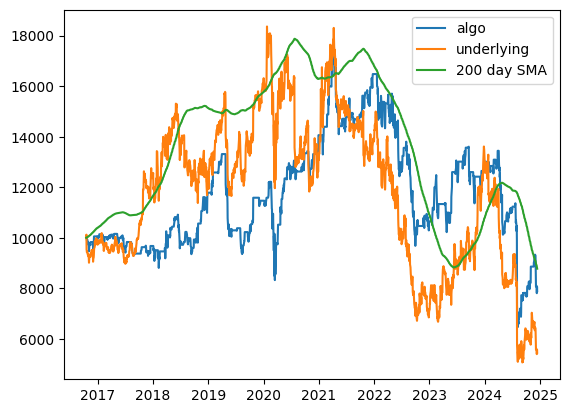

<Figure size 640x480 with 0 Axes>

In [534]:
plt.plot(df['equity'], label='algo')
plt.plot(df['underlying'], label='underlying')
plt.plot(df['scaled 200 day SMA'], label='200 day SMA')
plt.legend()
plt.show()
plt.clf()